In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.preprocessing import StandardScaler,RobustScaler
from xgboost import XGBRegressor


## Data Loading

In [2]:
Train_File = os.path.join('./data','house-prices-advanced-regression-techniques','train.csv')
Test_File = os.path.join('./data','house-prices-advanced-regression-techniques','test.csv')
train = pd.read_csv(Train_File)
test = pd.read_csv(Test_File)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Visualizing

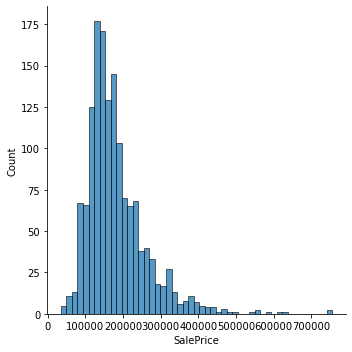

In [3]:
sns.displot(train['SalePrice'])
plt.show()

**Let the SalePrice become Guassian distribution**


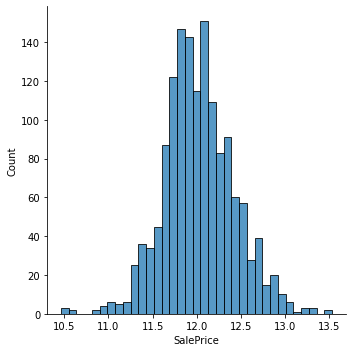

In [4]:
train['SalePrice'] = np.log1p(train['SalePrice'])#将他变成服从正态分布
sns.displot(train['SalePrice'])
plt.show()

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489450
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355879
WoodDeckSF      0.334135
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
Name: SalePrice, dtype: float64


<AxesSubplot:>

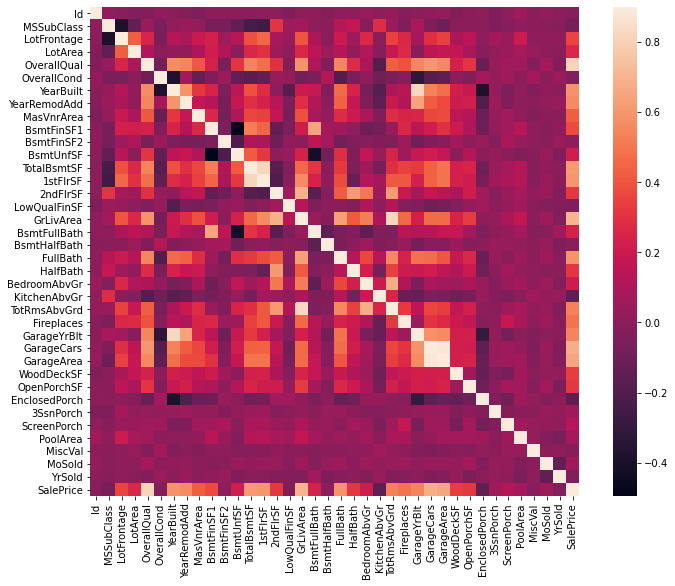

In [5]:
corrmat = train.corr()#获得相似度矩阵
print(corrmat['SalePrice'].sort_values(ascending=False)[:20])#展示前20个和标签有重要联系的特征
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True, linecolor='white')

<AxesSubplot:>

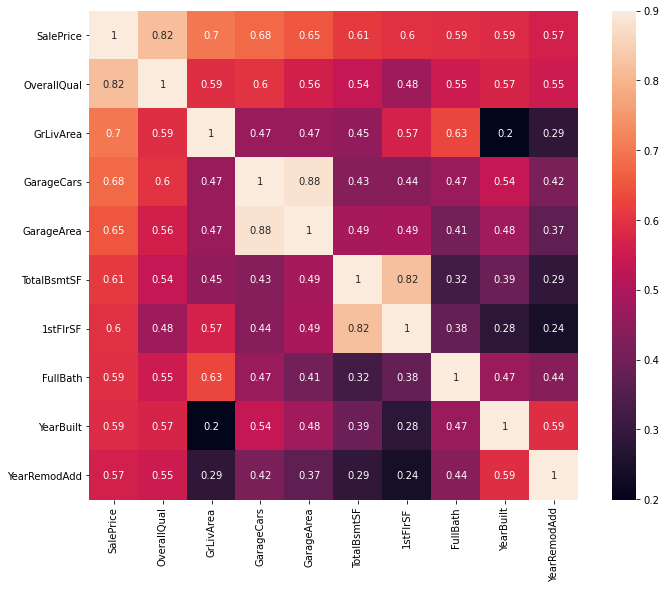

In [6]:
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index#局部运行，一步一步索引
cm = np.corrcoef(train[cols].values.T)
plt.subplots(figsize=(12,9))
sns.heatmap(cm, vmax=0.9,annot=True,square=True,annot_kws={'size':10},xticklabels=cols.values,yticklabels=cols.values)

When we find that the correlation between the label SalePrice and each Feature, so now here we want to have a
deep observation of that correlations.

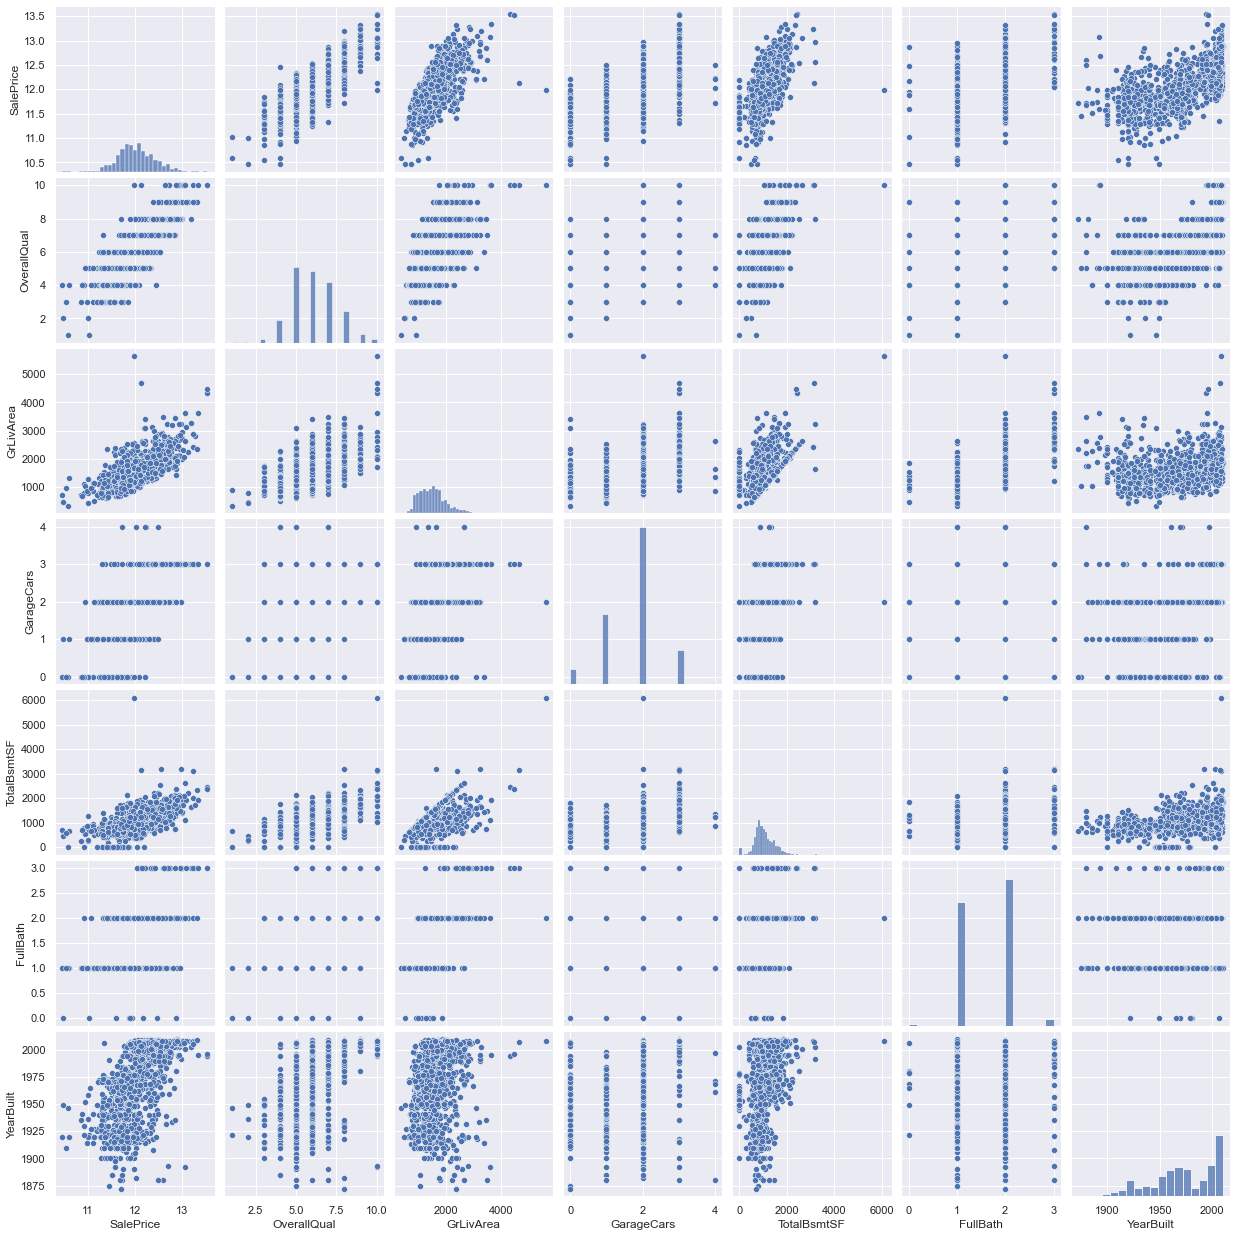

In [7]:
sns.set()
cols=['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',  'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height=2.5)
plt.show()


it is obvious that the features are all positive correlation with the label

## Data Cleaning


As we see above, the feature OverallQual,GrLivArea, GarageCars and GarageArea are more correlated with the label,
so we need to detect the outliers, which makes sure that they will not cause troubles in the following procedure

### GrlivArea,OverallQual,GarageCars,GarageArea,Scatter Graphes

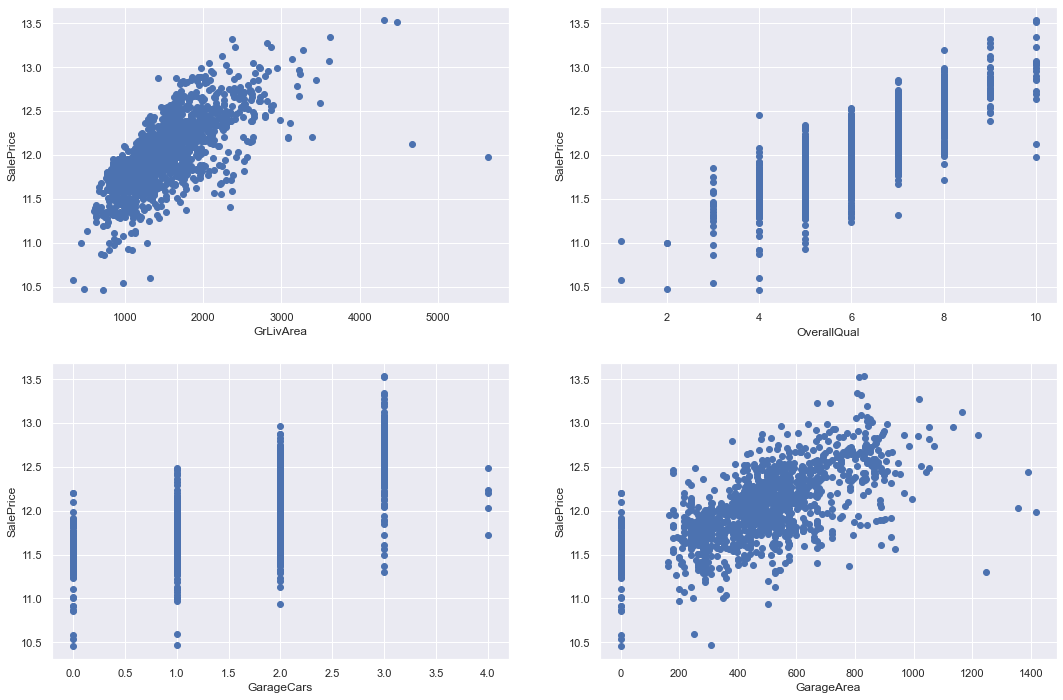

In [8]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(2,2,2)
plt.scatter(x = train['OverallQual'],y = train['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

plt.subplot(2,2,3)
plt.scatter(x = train['GarageCars'],y = train['SalePrice'])
plt.xlabel('GarageCars')
plt.ylabel('SalePrice')

plt.subplot(2,2,4)
plt.scatter(x = train['GarageArea'],y = train['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

plt.show()

### Handle the outlier in these four features

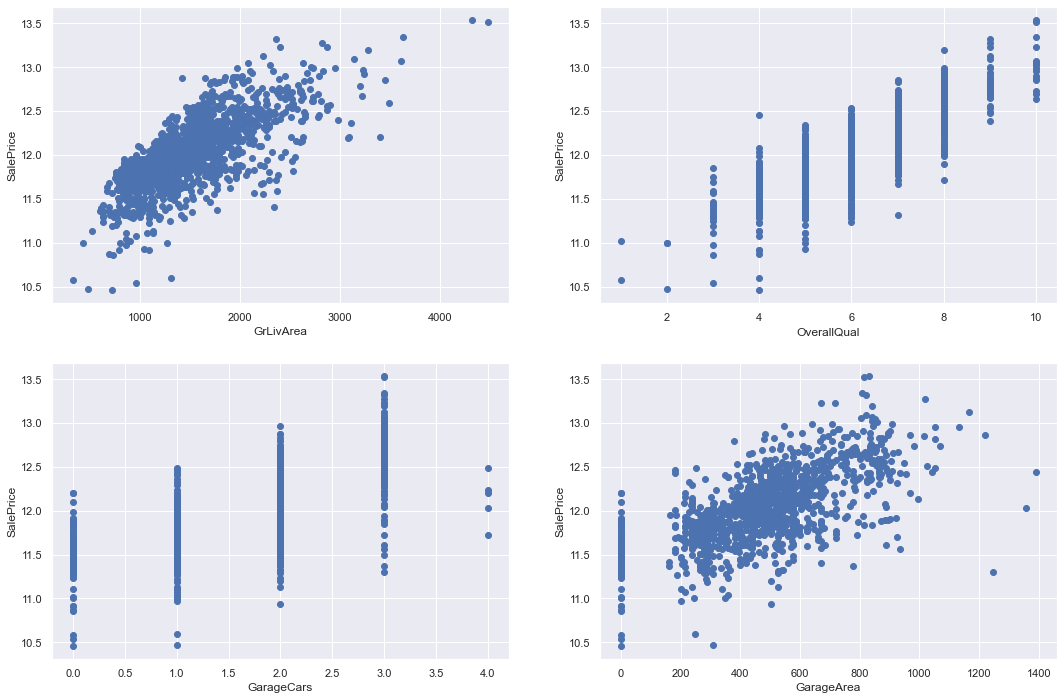

In [9]:
train.drop(index=train[(train['GrLivArea']>4000)&(train['SalePrice']<13)].index,inplace=True)
# train.drop(index=train[(train['OverallQual']<3)&(train['SalePrice']<12)].index,inplace=True)
# train.drop(index=train[(train['GarageCars']>4)&(train['SalePrice']>11)].index,inplace=True)
# train.drop(index=train[(train['GarageArea']>1400)&(train['SalePrice']>11)].index,inplace=True)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(2,2,2)
plt.scatter(x = train['OverallQual'],y = train['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

plt.subplot(2,2,3)
plt.scatter(x = train['GarageCars'],y = train['SalePrice'])
plt.xlabel('GarageCars')
plt.ylabel('SalePrice')

plt.subplot(2,2,4)
plt.scatter(x = train['GarageArea'],y = train['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

plt.show()

## Missing Data

### Data Concatenation

In [10]:
y_train = train['SalePrice']
train['source']='train'
test['source']='test'
test_id = test['Id']
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)
train.drop('SalePrice',axis=1,inplace=True)
all_features = pd.concat([train,test])
all_features.shape

(2917, 80)

In [11]:
def Missing_data_process(all_features):
    #Missing data处理，典型的确实值处理确实问题，我喜欢把缺失值、缺失值比例和数据类型都排在一起
    missing_data = all_features.isnull().sum().sort_values(ascending = False)
    missing_precent = ((all_features.isnull().sum())/(all_features.isnull().count())).sort_values(ascending=False)
    missing_type = all_features.dtypes
    missing_all = pd.concat([missing_data,missing_precent,missing_type],axis=1,keys=['missing_data','missing_precent','missing_type'])
    missing_all.drop(missing_all[missing_data==0].index,inplace=True)
    missing_all = missing_all.sort_values(by='missing_data',ascending=False)
    print(missing_all)
    return missing_all

In [12]:
missing_all = Missing_data_process(all_features)

              missing_data  missing_precent missing_type
PoolQC                2908         0.996915       object
MiscFeature           2812         0.964004       object
Alley                 2719         0.932122       object
Fence                 2346         0.804251       object
FireplaceQu           1420         0.486802       object
LotFrontage            486         0.166610      float64
GarageFinish           159         0.054508       object
GarageYrBlt            159         0.054508      float64
GarageQual             159         0.054508       object
GarageCond             159         0.054508       object
GarageType             157         0.053822       object
BsmtCond                82         0.028111       object
BsmtExposure            82         0.028111       object
BsmtQual                81         0.027768       object
BsmtFinType2            80         0.027425       object
BsmtFinType1            79         0.027083       object
MasVnrType              24     

<AxesSubplot:>

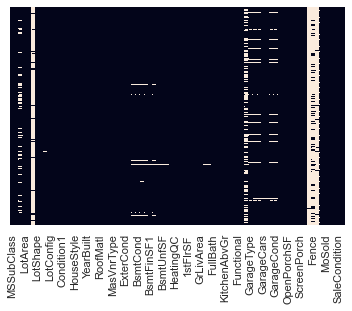

In [13]:
sns.heatmap(all_features.isnull(),yticklabels=False,cbar=False)

In [14]:
# Let's first input the missing values of LotFrontage based on the median of LotArea and Neighborhood. 
# Since LotArea is a continuous feature, We use qcut to divide it into 10 parts.
all_features.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [15]:
all_features["LotAreaCut"] = pd.qcut(all_features.LotArea,10)
all_features.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [16]:
all_features['LotFrontage']=all_features.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
all_features['LotFrontage']=all_features.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [17]:
# Then we filling in other missing values according to data_description.
# fill with in zero
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    all_features[col].fillna(0, inplace=True)

# fill in with 'None'
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    all_features[col].fillna("None", inplace=True)

# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    all_features[col].fillna(all_features[col].mode()[0], inplace=True)

In [18]:
missing_all = Missing_data_process(all_features)

Empty DataFrame
Columns: [missing_data, missing_precent, missing_type]
Index: []


<AxesSubplot:>

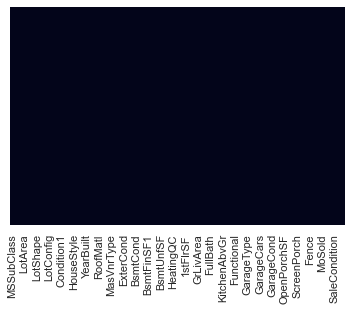

In [19]:
sns.heatmap(all_features.isnull(),yticklabels=False,cbar=False)
#没有missing value了

# 4.2 顺序特征编码
数据特征中存在一些顺序变量(ordinal variable),它们不同于一般的类型变量（categorical variable），顺序变量之间存在固有的顺序 比如 (低, 中, 高) 、病人疼痛指数 ( 1 到 10 - 但是他们之间的差是没有意义的, 因为1 到 10 仅仅表现了顺序)。
对于顺序变量，标签编码（LabelEncoder）的方式无法正确识别这种顺序关系。

In [20]:
## 定义函数对顺序变量进行编码
def custom_coding(x):
    if(x=='Ex'):
        r = 0
    elif(x=='Gd'):
        r = 1
    elif(x=='TA'):
        r = 2
    elif(x=='Fa'):
        r = 3
    elif(x=='None'):
        r = 4
    else:
        r = 5
    return r
## 顺序变量特征编码
cols = ['BsmtCond','BsmtQual','ExterCond','ExterQual','GarageCond','GarageQual','HeatingQC','KitchenQual']
for col in cols:
    all_features[col] = all_features[col].apply(custom_coding)
    
del cols, col

# 4.3 类别型特征变量
一些特征其被表示成数值特征缺乏意义，例如年份还有类别，这里将其转换为字符串，即类别型变量

In [21]:
cols = ['MSSubClass', 'YrSold', 'MoSold', 'OverallCond', "MSZoning", "BsmtFullBath", "BsmtHalfBath", "HalfBath",\
        "Functional", "Electrical", "KitchenQual","KitchenAbvGr", "SaleType", "Exterior1st", "Exterior2nd", "YearBuilt", \
        "YearRemodAdd", "GarageYrBlt","BedroomAbvGr","LowQualFinSF"]
for col in cols:
    all_features[col] = all_features[col].astype(str)    
del cols, col

# 4.4 字符型特征标签编码
除了前面已经做了顺序特征编码的特征，这里需要对其他字符型特征进行数值型编码。对于字符型特征可以采用独热编码(OneHotEncoder)和标签编码(LabelEncoder)编码方式将字符型特征转换成数值型特征。

使用LabelEncoder和get_dummies来实现这些功能。
首先，对年份类的数据等进行LabelEncoder编码（由于建造年份 (YearBuilt) 这个特征存在较多的取值 (从1872年到2010年)，直接进行独热编码会造成过于稀疏的数据，并且严重增加特征维度，因此在特征工程中会将其利用LabelEncoder进行数字化编码 ）。

In [22]:
from sklearn.preprocessing import LabelEncoder
str_cols = ["YearBuilt", "YearRemodAdd", 'GarageYrBlt', "YrSold", 'MoSold']
for col in str_cols:
    all_features[col] = LabelEncoder().fit_transform(all_features[col])


In [23]:
## 为了后续构建有意义的其他特征而进行标签编码
lab_cols = ['Heating','BsmtFinType1', 'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope', \
            'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', \
            'MSZoning','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','Exterior1st','MasVnrType',\
            'Foundation', 'GarageType','SaleType','SaleCondition']

for col in lab_cols:
    new_col = "labfit_" + col
    all_features[new_col] = LabelEncoder().fit_transform(all_features[col]) 
        
del col,str_cols,lab_cols,new_col

# 4.5 构建新的有意义的特征
区域相关特征对于确定房价非常重要，因此这里增加了一个表征每个房屋的地下室，一楼和二楼的总面积的特征。

In [24]:
# all_features['TotalHouseArea'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

房屋改造时间（YearsSinceRemodel）与房屋出售时间（YrSold）间隔时间的长短通常也会影响房价

In [25]:
# all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)

房屋的整体质量特征也是影响房价的重要要因素

In [26]:
# all_features['Total_Home_Quality'] = all_features['OverallQual'].astype(int) + all_features['OverallCond'].astype(int)

房屋内某些区域空间的有无通常也是影响房屋价格的重要因素，例如有三季门廊区(3SsnPorch)、开放式门廊（OpenPorchSF）的房屋可能就比没有三级门廊区的房屋价格贵。因此这里我们再增添几个特征用于描述房屋内是否存在这些区域空间。

In [27]:
# all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
# all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
# all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
# all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
# all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1

In [28]:
# all_features["TotalAllArea"] = all_features["TotalHouseArea"] + all_features["GarageArea"]                 # 房屋总面积加车库面积
# all_features["TotalHouse_and_OverallQual"] = all_features["TotalHouseArea"] * all_features["OverallQual"]  # 房屋总面积和房屋材质指标乘积
# all_features["GrLivArea_and_OverallQual"] = all_features["GrLivArea"] * all_features["OverallQual"]        # 地面上居住总面积和房屋材质指标乘积
# all_features["LotArea_and_OverallQual"] = all_features["LotArea"] * all_features["OverallQual"]            # 地段总面积和房屋材质指标乘积
# all_features["MSZoning_and_TotalHouse"] = all_features["labfit_MSZoning"] * all_features["TotalHouseArea"] # 一般区域分类与房屋总面积的乘积
# all_features["MSZoning_and_OverallQual"] = all_features["labfit_MSZoning"] + all_features["OverallQual"]   # 一般区域分类指标与房屋材质指标之和
# all_features["MSZoning_and_YearBuilt"] = all_features["labfit_MSZoning"] + all_features["YearBuilt"]       # 一般区域分类指标与初始建设年份之和
# ## 地理邻近环境位置指标与总房屋面积之积
# all_features["Neighborhood_and_TotalHouse"] = all_features["labfit_Neighborhood"] * all_features["TotalHouseArea"]
# all_features["Neighborhood_and_OverallQual"] = all_features["labfit_Neighborhood"] + all_features["OverallQual"]
# all_features["Neighborhood_and_YearBuilt"] = all_features["labfit_Neighborhood"] + all_features["YearBuilt"]
# all_features["BsmtFinSF1_and_OverallQual"] = all_features["BsmtFinSF1"] * all_features["OverallQual"]      # 1型成品的面积和房屋材质指标乘积
# ## 家庭功能评级指标与房屋总面积的乘积
# all_features["Functional_and_TotalHouse"] = all_features["labfit_Functional"] * all_features["TotalHouseArea"]
# all_features["Functional_and_OverallQual"] = all_features["labfit_Functional"] + all_features["OverallQual"]
# all_features["TotalHouse_and_LotArea"] = all_features["TotalHouseArea"] + all_features["LotArea"]
# ## 房屋与靠近公路或铁路指标乘积系数
# all_features["Condition1_and_TotalHouse"] = all_features["labfit_Condition1"] * all_features["TotalHouseArea"]
# all_features["Condition1_and_OverallQual"] = all_features["labfit_Condition1"] + all_features["OverallQual"]
# all_features["Bsmt"] = all_features["BsmtFinSF1"] + all_features["BsmtFinSF2"] + all_features["BsmtUnfSF"]     # 地下室相关面积总和指标
# all_features["Rooms"] = all_features["FullBath"]+all_features["TotRmsAbvGrd"]                              # 地面上全浴室和地面上房间总数量之和
# ## 开放式门廊、围廊、三季门廊、屏风玄关总面积
# all_features["PorchArea"] = all_features["OpenPorchSF"]+all_features["EnclosedPorch"]+ \
#                         all_features["3SsnPorch"]+all_features["ScreenPorch"]
# ## 全部功能区总面积（房屋、地下室、车库、门廊等）
# all_features["TotalPlace"] = all_features["TotalAllArea"] + all_features["PorchArea"]

# 4.6 连续变量特征的数据变换：改变源特征数据的分布


#### 优势
- 变换后可以更加便捷的发现数据之间的关系：从没有关系变成有关系，使得模型更好利用数据；
- 很多特征的数据呈现严重的偏态分布（例如：很多偏小的值聚在一起），变换后可以拉开差异；
- 让数据符合模型理论所需要的假设，然后对其进行分析，例如变换后的数据呈现正态分布；


取对数之后数据的性质和相关关系不会发生改变，但压缩了变量的尺度，大大方便了计算。
此处，绘制每个数值型特征与目标变量的分布情况：

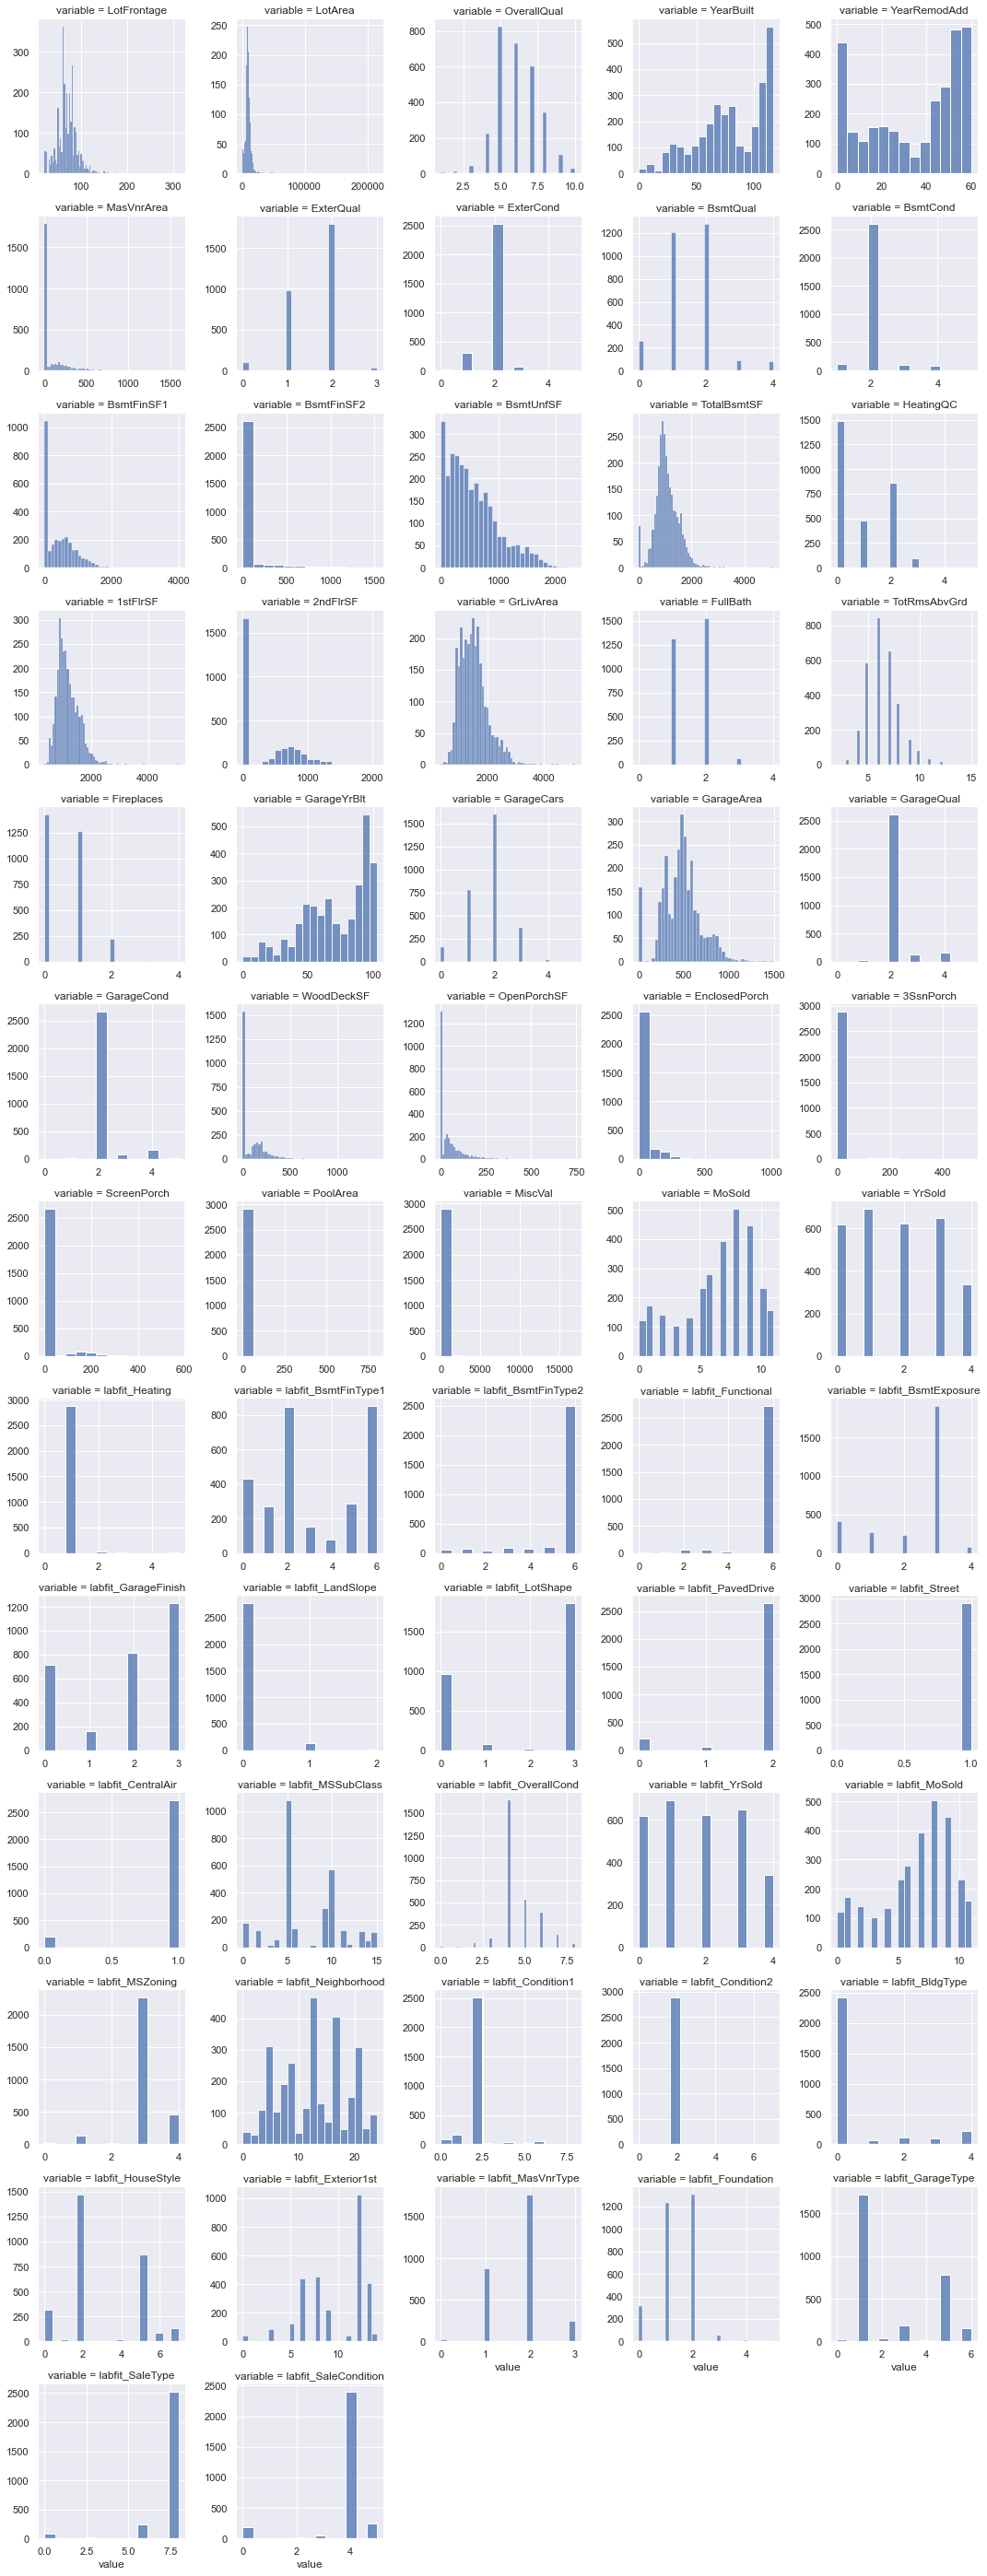

In [29]:
num_features = all_features.select_dtypes(include=['int64','float64','int32']).copy()
# num_features.drop(['SalePrice'],axis=1,inplace=True)               # 去掉目标值房价列

num_feature_names = list(num_features.columns)

num_features_data = pd.melt(all_features, value_vars=num_feature_names)
g = sns.FacetGrid(num_features_data, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
plt.show()

计算各数值型特征变量的偏度(skewness)

In [30]:
from scipy.stats import norm, skew       
skewed_feats = all_features[num_feature_names].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness[skewness["Skew"].abs()>0.75]

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
labfit_Condition2,12.340989
labfit_Heating,12.074570
3SsnPorch,11.372080
labfit_LandSlope,4.973254
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


- 根据图像显示，可以看到数值型特征变量偏移程度，此处设置阈值为1，对偏度大于阈值的特征进行log函数变换操作以提升质量。

In [31]:
skew_cols = list(skewness[skewness["Skew"].abs()>1].index)
for col in skew_cols:
    #all_features[col] = boxcox1p(all_features[col], 0.15)                                  # 偏度超过阈值的特征做box-cox变换
    all_features[col] = np.log1p(all_features[col])                                         # 偏度超过阈值的特征对数变换
    
del num_features, num_feature_names, num_features_data, g, skewed_feats, col, skew_cols      # 清除临时变量

# 4.7 字符型特征的独热编码

查看当前的数据情况如下：

In [32]:
all_features.info()
all_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Columns: 108 entries, MSSubClass to labfit_SaleCondition
dtypes: category(1), float64(35), int32(16), int64(11), object(45)
memory usage: 2.3+ MB


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,labfit_Condition1,labfit_Condition2,labfit_BldgType,labfit_HouseStyle,labfit_Exterior1st,labfit_MasVnrType,labfit_Foundation,labfit_GarageType,labfit_SaleType,labfit_SaleCondition
0,60,RL,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,1.098612,1.098612,0.0,5,12,1,2,1,2.197225,1.609438
1,20,RL,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.693147,1.098612,0.0,2,8,2,1,1,2.197225,1.609438
2,60,RL,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,1.098612,1.098612,0.0,5,12,1,2,1,2.197225,1.609438
3,70,RL,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,1.098612,1.098612,0.0,5,13,2,0,5,2.197225,0.000000
4,60,RL,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,1.098612,1.098612,0.0,5,12,1,2,1,2.197225,1.609438


可见，当前数据集中还存在字符型特征变量没有处理，对于这些剩下的字符型特征，采用独热编码的方式，将其转化为数值型的特征。

In [33]:
all_features = pd.get_dummies(all_features)       # 一键独热编码

查看数据查看数据特征，可见目前所有非数值型特征都经过编码成了数值型

In [34]:
all_features.info()
all_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Columns: 386 entries, LotFrontage to LotAreaCut_(14285.8, 215245.0]
dtypes: float64(35), int32(16), int64(11), uint8(324)
memory usage: 2.2 MB


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,"LotAreaCut_(1299.999, 4921.8]","LotAreaCut_(4921.8, 7007.2]","LotAreaCut_(7007.2, 7949.0]","LotAreaCut_(7949.0, 8740.4]","LotAreaCut_(8740.4, 9452.0]","LotAreaCut_(9452.0, 10148.8]","LotAreaCut_(10148.8, 11000.0]","LotAreaCut_(11000.0, 12196.8]","LotAreaCut_(12196.8, 14285.8]","LotAreaCut_(14285.8, 215245.0]"
0,65.0,9.042040,7,110,53,5.283204,1,2,1,1.098612,...,0,0,0,1,0,0,0,0,0,0
1,80.0,9.169623,6,83,26,0.000000,2,2,1,1.098612,...,0,0,0,0,0,1,0,0,0,0
2,68.0,9.328212,7,108,52,5.093750,1,2,1,1.098612,...,0,0,0,0,0,0,0,1,0,0
3,60.0,9.164401,7,25,20,0.000000,2,2,2,0.693147,...,0,0,0,0,0,1,0,0,0,0
4,84.0,9.565284,8,107,50,5.860786,1,2,1,1.098612,...,0,0,0,0,0,0,0,0,1,0


至此，所有字符型特征变量都编码成了数值型特征。

# 4.8 特征降维

从4.7节可以看出，当前数据中总共有394维特征，这些特征中有部分特征对于后续的模型训练意义不大，因此，我们可以采用一些方式将这些无意义的特征进行剔除。特征降维的方式也有很多种，例如主成分分析，这里根据特征的重要性图来进行选择出利于模型训练的关键特征，从而达到特征降维的目的。由于套索回归模型（Lasso）的系数可以表证特征的重要程度，因此本次案例使用套索回归对经过上述处理的数据集进行训练，获取模型的系数，利用它们缩减无意义的特征。

## 将数据拆分回训练和测试数据

In [35]:
def split_data(all_features):
    cols = list(all_features.columns)
    for col in cols:        # 可能特征工程的过程中会产生极个别异常值（正负无穷大），这里用众数填充
        all_features[col].values[np.isinf(all_features[col].values)] = all_features[col].median()   
    del cols, col

    train_data = all_features[all_features['source_train']==1]
    test_data = all_features[all_features['source_test']==1]

    x_train = train_data.copy()
    x_test = test_data.copy()

    x_train.drop(['source_train','source_test'],axis=1,inplace=True)
    x_test.drop(['source_train','source_test'],axis=1,inplace=True)

    return x_train,x_test
x_train, x_test = split_data(all_features)
# all_features.drop(['source_train','source_test'],axis=1,inplace=True)

## 对特征进行归一化

In [36]:
scaler = RobustScaler()
x_train = scaler.fit(x_train).transform(x_train)  #训练样本特征归一化
x_test = scaler.transform(x_test)                 #测试集样本特征归一化

## 特征选择：基于特征重要性图

In [37]:
from sklearn.linear_model import Lasso
lasso_model=Lasso(alpha=0.001)
lasso_model.fit(x_train,y_train)

# 索引和重要性做成dataframe形式
FI_lasso = pd.DataFrame({"Feature Importance":lasso_model.coef_},index=all_features.drop(['source_train','source_test'],axis=1).columns) 
# 由高到低进行排序
FI_lasso.sort_values("Feature Importance",ascending=False).round(5) 

,Feature Importance
OverallQual,0.11059
GrLivArea,0.09396
YearBuilt,0.09099
2ndFlrSF,0.08945
Neighborhood_Crawfor,0.08223
...,...
KitchenAbvGr_2,-0.02657
HeatingQC,-0.02794
CentralAir_N,-0.03237
MSZoning_RM,-0.03468


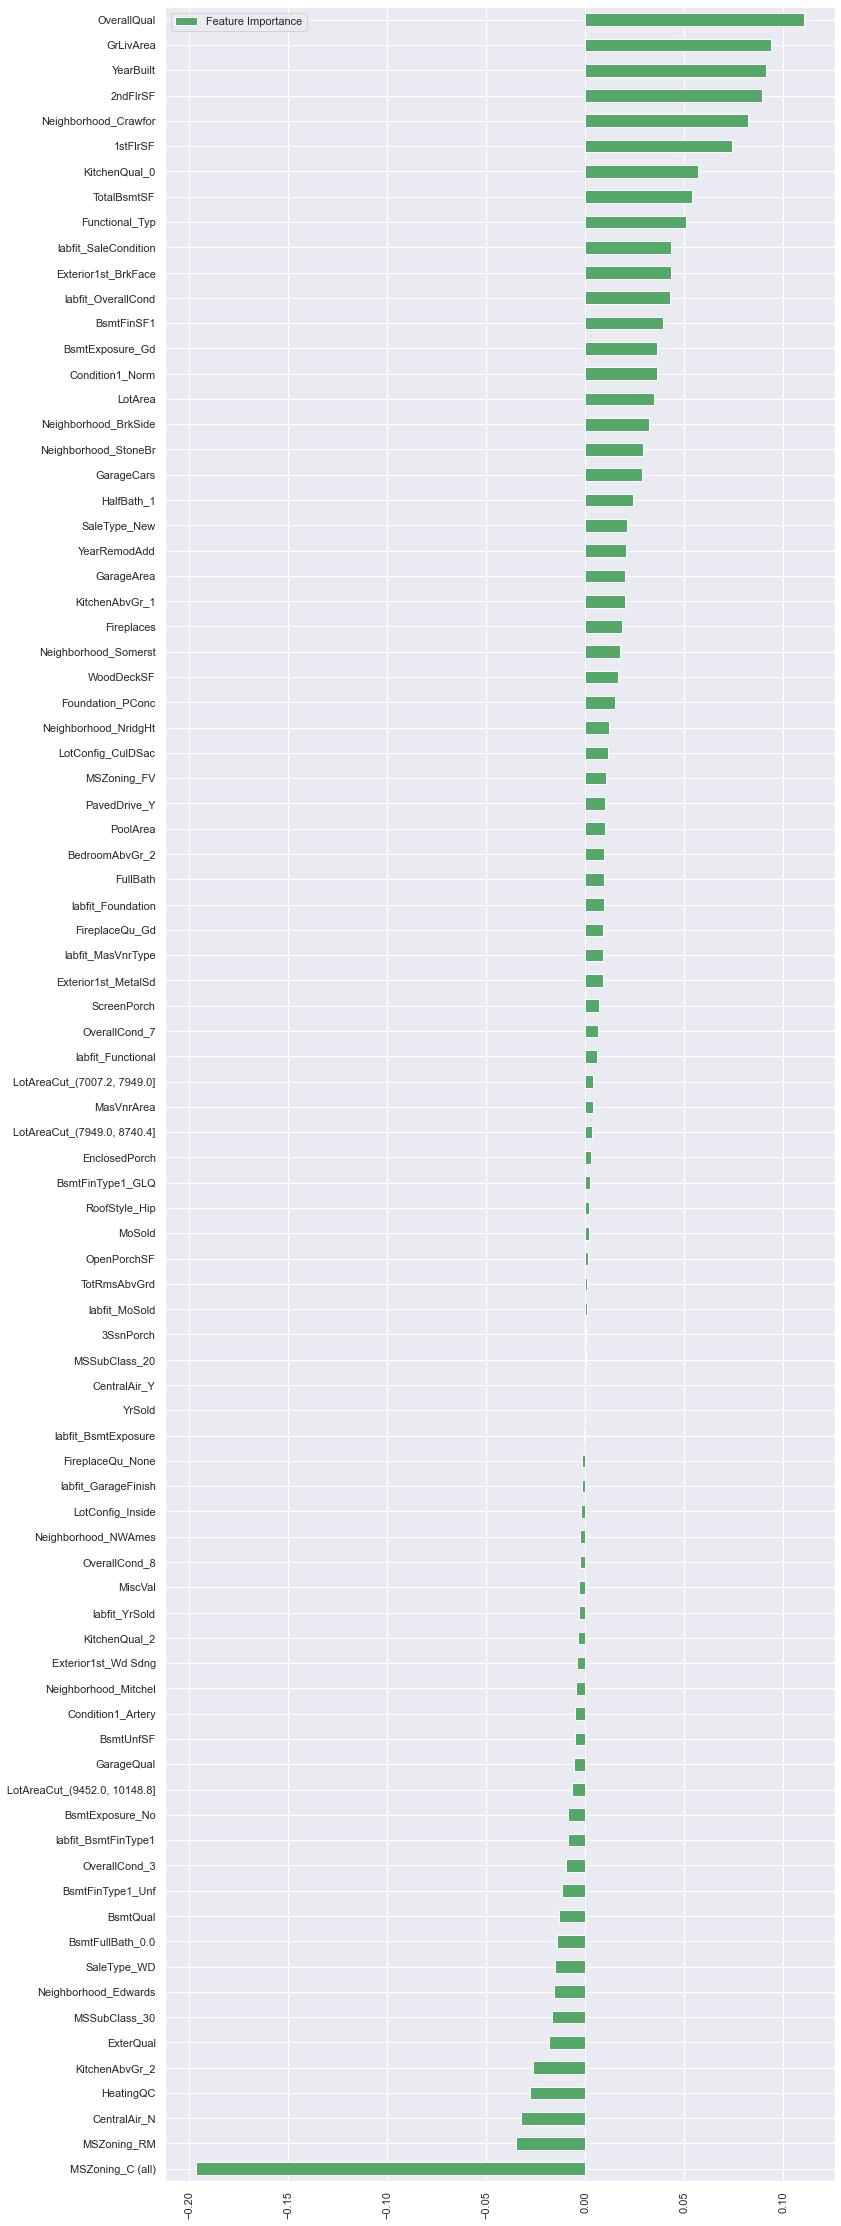

(384, 1)


In [38]:
# 获取重要程度大于0的系数指标
FI_lasso[FI_lasso["Feature Importance"] !=0 ].sort_values("Feature Importance").plot(kind="barh",figsize=(12,40), color='g')
plt.xticks(rotation=90)
plt.show()

FI_index = FI_lasso.index
FI_val = FI_lasso["Feature Importance"].values
FI_lasso = pd.DataFrame(FI_val, columns = ['Feature Importance'], index = FI_index)
print(FI_lasso.shape)

选择重要程度大于0的数据

In [39]:
choose_cols = FI_lasso[FI_lasso["Feature Importance"] >= 0].index.tolist()
choose_cols.append('source_train')
choose_cols.append('source_test')
choose_data = all_features[choose_cols].copy()


# 4.9 主成分分析

In [40]:
# 分割数据集
x_train = choose_data[choose_data['source_train']==1].drop(['source_train','source_test'],axis=1)
x_test = choose_data[choose_data['source_test']==1].drop(['source_train','source_test'],axis=1)

# 归一化
scaler = RobustScaler()
x_train = scaler.fit(x_train).transform(x_train)  #训练样本特征归一化
x_test = scaler.transform(x_test)                 #测试集样本特征归一化
y_train = y_train.values.reshape(-1,1)

# PCA
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=348)
# x_train = pca_model.fit_transform(x_train)
# x_test = pca_model.transform(x_test)

# 5 数据建模

In [41]:
def score_dataset(X, y, model):
    score = sklearn.model_selection.cross_val_score(
        model, X, y, cv=10, scoring='neg_mean_squared_error'
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.08, max_depth=3,
#                    min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640,
#                    reg_lambda=0.8571,subsample=0.5213, random_state =7, nthread = -1)
xgb_params = dict(
    max_depth=4,                           # maximum depth of each tree - try 2 to 10
    learning_rate=0.0058603076512435655,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=5045,                     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=2,                    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.22556099175248345,   # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.5632348136091383,          # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.09888625622197889,        # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.00890758697724437,         # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,                   # set > 1 for boosted random forests
    
)
xgb_model = XGBRegressor(**xgb_params)

print(score_dataset(x_train,y_train,xgb_model))

0.1109830985251166


In [42]:
# from xgboost import XGBRegressor
# # from lightgbm import LGBMRegressor
#
# xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05, max_depth=3,
#                    min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640,
#                    reg_lambda=0.8571,subsample=0.5213, silent=1,random_state =7, nthread = -1)

xgb_model.fit(x_train, y_train)
y_predict_xgb = pd.DataFrame(np.expm1(xgb_model.predict(x_test)),columns=['SalePrice'],dtype=int)
#
submission_xgb = pd.concat([test_id, y_predict_xgb], axis=1)


In [43]:
# submission_xgb.head(5)

In [44]:
submission_xgb.to_csv('submission_xgb4_dataprocessed_1.csv',index=False)
print("Your predictions are successfully saved!")

Your predictions are successfully saved!
